# Heterogeneous Effects

**Prerequisites**

- applications/regression  
- applications/ml_in_economics  


**Outcomes**

- Understand potential outcomes and treatment effects  
- Apply generic machine learning inference to data from a randomized experiment  

In [1]:
import pandas as pd
import numpy as np
import patsy
from sklearn import linear_model, ensemble, base, neural_network
import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In this notebook, we will learn how to apply machine learning methods to analyze
the results of a randomized experiment. We typically begin analyzing
the results of an experiment by calculating the difference in mean
outcomes between the treated and control groups. This difference is a
good estimate of the average treatment effect. We can obtain more
nuanced results by recognizing that the effect of most experiments
might be heterogeneous. That is, different people could be affected by
the experiment differently. We will use machine learning methods to
explore this heterogeneity in treatment effects.

## Background and Data

We are going to use data from a randomized experiment in Indonesia
called Program Keluarga Harapan (PKH). PKH was a conditional cash
transfer program designed to improve child health. Eligible pregnant
women would receive a cash transfer if they attendend at least 4
pre-natal and 2 post-natal visits, recieved iron supplements, and had
their baby delivered by a doctor or midwife. The cash transfers were
given quarterly and were about 60-220 dollars or 15-20 percent of
quarterly consumption. PKH eligibility was randomly assigned at the
kecamatan (district) level. All pregnant women living in a treated
kecamatan could choose to participate in the experiment. For more
information see [[ACE+11]](#alatas2011) or [[Tri16]](#triyana2016) .

We are using the data provided with [[Tri16]](#triyana2016) .

In [2]:
url = "https://storage.googleapis.com/qeds/data/Triyana_2016_price_women_clean.csv.gz"
df = pd.read_csv(url)
df.describe()

,rid_panel,prov,Location_ID,dist,wave,edu,agecat,log_xp_percap,rhr031,rhr032,...,hh_xp_all,tv,parabola,fridge,motorbike,car,pig,goat,cow,horse
count,1.225100e+04,22768.000000,2.277100e+04,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,...,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.000000,22771.00000,22771.000000,22771.000000
mean,3.406884e+12,42.761156,4.286882e+06,431842.012033,1.847174,52.765799,4.043081,13.420404,0.675157,0.754908,...,3.839181,0.754908,0.482148,0.498661,0.594792,0.470511,0.536691,0.53858,0.515041,0.470247
std,1.944106e+12,14.241982,1.423541e+06,143917.353784,0.875323,45.833778,1.280589,1.534089,0.468326,0.430151,...,1.481982,0.430151,0.499692,0.500009,0.490943,0.499141,0.498663,0.49852,0.499785,0.499125
min,1.100103e+10,31.000000,3.175010e+06,3524.000000,1.000000,6.000000,0.000000,7.461401,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.731008e+12,32.000000,3.210180e+06,323210.000000,1.000000,6.000000,3.000000,11.972721,0.000000,1.000000,...,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,3.491004e+12,35.000000,3.517171e+06,353517.000000,2.000000,12.000000,5.000000,12.851639,1.000000,1.000000,...,5.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,0.000000
75%,5.061008e+12,53.000000,5.307020e+06,535307.000000,3.000000,99.000000,5.000000,15.018967,1.000000,1.000000,...,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
max,6.681013e+12,75.000000,7.571030e+06,757571.000000,3.000000,99.000000,5.000000,15.018967,1.000000,1.000000,...,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


## Potential Outcomes and Treatment Effects

Since program eligibility is what was randomly assigned (and what
policymakers could choose to change), we will focus on estimating
the effect of being eligible for these cash transfers. We will let
$ d_i $ be a 1 if person $ i $ was eligible and be 0 if person
$ i $ was not. Let $ y_i $ be an outcome of interest. Below we
will look at usage of midwives and birthweight as outcomes.

For thinking about the effect of the treatment on the outcome, it is
useful to think about potential outcomes. The potential treated
outcome is $ y_i(1) $. For subjects who actually were treated,
$ y_i(1) = y_i $ is the observed outcome. For untreated subjects,
$ y_i(1) $ is what mother i ‘s baby’s birthweight would have
been if she had been eligible for the program. Similarly, we can
define the potential untreated outcome $ y_i(0) $ .

The individual treatment effect for subject i is simply $ y_i(1) - y_i(0) $
. Individual treatment effects are impossible to know since we always
only observe $ y_i(1) $ or $ y_i(0) $ , but never both.

When treatment is randomly assigned, we can estimate average treatment
effects because

$$
\begin{align*}
E[y_i(1) - y_i(0) ] = & E[y_i(1)] - E[y_i(0)] \\
& \text{random assignment } \\
= & E[y_i(1) | d_i = 1] - E[y_i(0) | d_i = 0] \\
= & E[y_i | d_i = 1] - E[y_i | d_i = 0 ]
\end{align*}
$$

### Average Treatment Effects

Let’s estimate the average treatment effect.

In [3]:
# some data prep for later
formula = """
bw ~ pkh_kec_ever +
  C(edu)*C(agecat) + log_xp_percap + hh_land + hh_home + C(dist) +
  hh_phone + hh_rf_tile + hh_rf_shingle + hh_rf_fiber +
  hh_wall_plaster + hh_wall_brick + hh_wall_wood + hh_wall_fiber +
  hh_fl_tile + hh_fl_plaster + hh_fl_wood + hh_fl_dirt +
  hh_water_pam + hh_water_mechwell + hh_water_well + hh_water_spring + hh_water_river +
  hh_waterhome +
  hh_toilet_own + hh_toilet_pub + hh_toilet_none +
  hh_waste_tank + hh_waste_hole + hh_waste_river + hh_waste_field +
  hh_kitchen +
  hh_cook_wood + hh_cook_kerosene + hh_cook_gas +
  tv + fridge + motorbike + car + goat + cow + horse
"""
bw, X = patsy.dmatrices(formula, df, return_type="dataframe")
# some categories are empty after dropping rows will Null, drop now
X = X.loc[:, X.sum() > 0]
bw = bw.iloc[:, 0]
treatment_variable = "pkh_kec_ever"
treatment = X["pkh_kec_ever"]
Xl = X.drop(["Intercept", "pkh_kec_ever", "C(dist)[T.313175]"], axis=1)
#scale = bw.std()
#center = bw.mean()
loc_id = df.loc[X.index, "Location_ID"].astype("category")

import re
# remove [ ] from names for compatibility with xgboost
Xl = Xl.rename(columns=lambda x: re.sub('\[|\]','_',x))

In [4]:
# Estimate average treatment effects
from statsmodels.iolib.summary2 import summary_col
tmp = pd.DataFrame(dict(birthweight=bw,treatment=treatment,assisted_delivery=df.loc[X.index, "good_assisted_delivery"]))
usage = smf.ols("assisted_delivery ~ treatment", data=tmp).fit(cov_type="cluster", cov_kwds={'groups':loc_id})
health= smf.ols("bw ~ treatment", data=tmp).fit(cov_type="cluster", cov_kwds={'groups':loc_id})
summary_col([usage, health])

,assisted_delivery,bw
Intercept,0.7827,3173.4067
,(0.0124),(10.2323)
treatment,0.0235,-14.8992
,(0.0192),(24.6304)


The program did increase the portion of births assisted by a medical
professional, but on average had no effect on birthweight.

### Conditional Average Treatment Effects

Although we can never estimate individual treatment effects, the same
logic that let’s us estimate unconditional average treatment effects,
also suggests that we can estimate conditional average treatment effects.

$$
\begin{align*}
E[y_i(1) - y_i(0) |X_i=x] = & E[y_i(1)|X_i = x] - E[y_i(0)|X_i=x] \\
& \text{random assignment } \\
= & E[y_i(1) | d_i = 1, X_i=x] - E[y_i(0) | d_i = 0, X_i=x] \\
= & E[y_i | d_i = 1, X_i = x] - E[y_i | d_i = 0, X_i=x ]
\end{align*}
$$

Conditional average treatment effects tell us whether there are
identifiable (by X) groups of people for whom treatment effects vary.

Since conditional average treatment effects involve conditional
expectations, machine learning methods might be useful.

However, if we want to be able to perform statistical inference, we
must use machine learning methods carefully. We will describe one
approach in detail below. [[AI16]](#athey2016b) and [[WA18]](#wager2018) are
alternative related approaches.

## Generic Machine Learning Inference

In this section, we will describe the “generic machine learning
inference” method of [[CDDFV18]](#cddf2018) to explore heterogeneity in
conditional average treatment effects.

This approach allows any
machine learning method to be used to estimate $ E[y_i(1) -
y_i(0) |X_i=x] $ .

Inference for functions estimated by machine learning methods is
typically either impossible or requires very restrictive assumptions.
[[CDDFV18]](#cddf2018) get around this problem by focusing on inference for
certain summary statistics of the machine learning prediction for
$ E[y_i(1) - y_i(0) |X_i=x] $ rather than
$ E[y_i(1) - y_i(0) |X_i=x] $ itself.

### Best Linear Projection of CATE

Let $ s_0(x) = E[y_i(1) - y_i(0) |X_i=x] $ denote the true
conditional average treatment effect. Let $ S(x) $ be an estimate
or noisy proxy for $ s_0(x) $ . One way to summarize how well
$ S(x) $ approximates $ s_0(x) $ is to look at the best linear
projection of $ s_0(x) $ on $ S(x) $

$$
\DeclareMathOperator*{\argmin}{arg\,min}
\beta_0, \beta_1 = \argmin_{b_0,b_1} E[(s_0(x) -
b_0 - b_1 (S(x)-E[S(x)]))^2]
$$

It is not difficult to show that $ \beta_0 = E[y_i(1) - y_i(0)] $
is the unconditional average treatment effect. More interestingly,
$ \beta_1 $ is related to how well $ S(x) $ approximates
$ s_0(x) $. If $ S(x) = s_0(x) $, then $ \beta_1=1 $. If
$ S(x) $ is completely uncorrelated with $ s_0(x) $, then
$ \beta_1 = 0 $.

The best linear projection of the conditional average treatement
effect tells us something about how well $ S(x) $ approximates
$ s_0(x) $, but it does not directly quantify how much the conditional
average treatment effect varies with $ x $. We could try looking
at $ S(x) $ directly, but if $ x $ is high dimensional, it is
difficult to report or visualize $ S(x) $ . Moreoever, for most
machine learning methods there is no satisfactory method for inference
on $ S(x) $ . This is very problematic if we want to use
$ S(x) $ to shape future policy decisions. For example we might
want to use $ S(x) $ to target the treatment to people with
different $ x $ . If we do this, we need to know whether the
estimated difference across $ x $ in $ S(x) $ are precise or
due to noise.

### Grouped Average Treatment Effects

To deal with both these issues, [[CDDFV18]](#cddf2018) propose focusing on
grouped average treatment effects (GATE) with groups defined by
$ S(x) $. Partition the data into a fixed, finite number of groups
based on $ S(x) $ . Let
$ G_{k}(x) = 1\{\ell_{k-1} \leq S(x) \leq \ell_k \} $ where
$ \ell_k $ could be constant chosen by the researcher or evenly
spaced quantiles of $ S(x) $. The $ k $ th grouped average
treatment effect is then $ \gamma_k = E[y(1) - y(0) | G_k(x)] $
. If the true $ s_0(x) $ is not constant, and $ S(x) $
approximates $ s_0(x) $ well, then the grouped average treatment
effects will increase with $ k $. If there is no heterogeneity in
the conditional average treatment efffect (i.e. $ s_0(x) $ is
constant) and/or $ S(x) $ is a poor approximation to
$ s_0(x) $, then the grouped average treatment effect will tend to
be constant with $ k $, and may even be non-monotonic due to
estimation error.

### Estimation

Both the best linear projection of the condtional average treatment
effect and grouped treatment effects can be estimated through
particular regressions. Let $ B(x) $ be an estimate of the outcome
conditional on no treatment, i.e. $ B(x) = \widehat{E[y(0)|x]} $
. Then the estimates of $ \beta $ from  the regression

$$
y_i = \alpha_0 + \alpha_1 B(x_i) + \beta_0 (d_i-P(d=1)) + \beta_1
(d_i-P(d=1))(S(x_i) - E[S(x_i)]) + \epsilon_i
$$

are consistent estimates of the best linear projection of the
conditional average treatement effect if $ B(x_i) $ and
$ S(x_i) $ are uncorrelated with $ y_i $ . We can ensure that
$ B(x_i) $ and $ S(x_i) $ are uncorrelated with $ y_i $ by
using the familiar idea of sample-splitting and cross-validation. The
usual regression standard errors will also be valid.

Similarly, grouped average treatment effects can be estimated from the
following regression.

y_i = alpha_0 + alpha_1 B(x_i) + sum_k gamma_k (d_i-P(d=1)) 1(G_k(x_i)) +
u_i

The resulting estimates of $ \gamma_k $ will be consistent and
asymptotically normal with the usual regression standard errors.

In [5]:
# for clustering standard errors
def get_treatment_se(fit, cluster_id, rows=None):
    if cluster_id is not None:
        if rows is None:
            rows = [True] * len(cluster_id)
        vcov = sm.stats.sandwich_covariance.cov_cluster(fit, cluster_id.loc[rows])
        return np.sqrt(np.diag(vcov))

    return fit.HC0_se

In [6]:
def generic_ml_model(x, y, treatment, model, n_split=10, n_group=5, cluster_id=None):
    nobs = x.shape[0]

    blp = np.zeros((n_split, 2))
    blp_se = blp.copy()
    gate = np.zeros((n_split, n_group))
    gate_se = gate.copy()

    baseline = np.zeros((nobs, n_split))
    cate = baseline.copy()
    lamb = np.zeros((n_split, 2))

    for i in range(n_split):
        main = np.random.rand(nobs) > 0.5
        rows1 = ~main & (treatment == 1)
        rows0 = ~main & (treatment == 0)

        mod1 = base.clone(model).fit(x.loc[rows1, :], (y.loc[rows1]))
        mod0 = base.clone(model).fit(x.loc[rows0, :], (y.loc[rows0]))

        B = mod0.predict(x)
        S = mod1.predict(x) - B
        baseline[:, i] = B
        cate[:, i] = S
        ES = S.mean()

        ## BLP
        # assume P(treat|x) = P(treat) = mean(treat)
        p = treatment.mean()
        reg_df = pd.DataFrame(dict(
            y=y, B=B, treatment=treatment, S=S, main=main, excess_S=S-ES
        ))
        reg = smf.ols("y ~ B + I(treatment-p) + I((treatment-p)*(S-ES))", data=reg_df.loc[main, :])
        reg_fit = reg.fit()
        blp[i, :] = reg_fit.params.iloc[2:4]
        blp_se[i, :] = get_treatment_se(reg_fit, cluster_id, main)[2:]

        lamb[i, 0] = reg_fit.params.iloc[-1]**2 * S.var()

        ## GATEs
        cutoffs = np.quantile(S, np.linspace(0,1, n_group + 1))
        cutoffs[-1] += 1
        for k in range(n_group):
            reg_df[f"G{k}"] = (cutoffs[k] <= S) & (S < cutoffs[k+1])

        g_form = "y ~ B + " + " + ".join([f"I((treatment-p)*G{k})" for k in range(n_group)])
        g_reg = smf.ols(g_form, data=reg_df.loc[main, :])
        g_fit = g_reg.fit()
        gate[i, :] = g_fit.params.values[2:] #g_fit.params.filter(regex="G").values
        gate_se[i, :] = get_treatment_se(g_fit, cluster_id, main)[2:]

        lamb[i, 1] = (gate[i,:]**2).sum()/n_group

    out = dict(
        gate=gate, gate_se=gate_se,
        blp=blp, blp_se=blp_se,
        Lambda=lamb, baseline=baseline, cate=cate,
        name=type(model).__name__
    )
    return out


def generic_ml_summary(generic_ml_output):
    out = {
        x: np.nanmedian(generic_ml_output[x], axis=0)
        for x in ["blp", "blp_se", "gate", "gate_se", "Lambda"]
    }
    out["name"] = generic_ml_output["name"]
    return out

In [7]:
kw = dict(x=Xl, treatment=treatment, n_split=11, n_group=5, cluster_id=loc_id)

In [8]:
def evaluate_models(models, y, **other_kw):
    all_kw = kw.copy()
    all_kw["y"] = y
    all_kw.update(other_kw)
    return list(map(lambda x: generic_ml_model(model=x, **all_kw), models))

In [9]:
def generate_report(results):
    summaries = list(map(generic_ml_summary, results))
    df_plot = pd.DataFrame({
        mod["name"]: np.median(mod["cate"], axis=1)
        for mod in results
    })

    print("Correlation in median CATE:")
    display(df_plot.corr())
    sns.pairplot(df_plot, diag_kind="kde", kind="reg")

    print("\n\nBest linear projection of CATE")
    df_cate = pd.concat({
        s["name"]: pd.DataFrame(dict(blp=s["blp"], se=s["blp_se"]))
        for s in summaries
    }).T.stack()
    display(df_cate)

    print("\n\nGroup average treatment effects:")
    df_groups = pd.concat({
        s["name"]: pd.DataFrame(dict(gate=s["gate"], se=s["gate_se"]))
        for s in summaries
    }).T.stack()
    display(df_groups)

In [10]:
import xgboost as xgb
models = [
    linear_model.LassoCV(cv=10, n_alphas=25, max_iter=500, tol=1e-4, n_jobs=1),
    ensemble.RandomForestRegressor(n_estimators=200, min_samples_leaf=20),
    xgb.XGBRegressor(n_estimators=200, max_depth=3, reg_lambda=2.0, reg_alpha=0.0, objective="reg:squarederror"),
    neural_network.MLPRegressor(hidden_layer_sizes=(20, 10), max_iter=500, activation="logistic",
                                solver="adam", tol=1e-3, early_stopping=True, alpha=0.0001)
]

In [11]:
results = evaluate_models(models, y=bw)

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

Correlation in median CATE:


,LassoCV,RandomForestRegressor,XGBRegressor,MLPRegressor
LassoCV,1.000000,0.409901,0.159584,-0.024349
RandomForestRegressor,0.409901,1.000000,0.477949,-0.102374
XGBRegressor,0.159584,0.477949,1.000000,0.007511
MLPRegressor,-0.024349,-0.102374,0.007511,1.000000




Best linear projection of CATE


LassoCV  MLPRegressor  RandomForestRegressor  XGBRegressor
blp 0  -1.064181     -5.286263              -8.350920    -16.829250
    1  -0.001457    -41.373386              -0.075019      0.047419
se  0  33.377629     33.215706              32.359689     33.160789
    1   0.672855   3317.446106               0.282156      0.118524



Group average treatment effects:


LassoCV  MLPRegressor  RandomForestRegressor  XGBRegressor
gate 0   2.546526     22.043918              38.925583     -7.821914
     1   0.000000    -48.871658             -32.137768     26.053409
     2  27.955858     -7.429945              -8.166054    -50.987444
     3 -34.739623     -3.640581             -32.125172    -15.843836
     4  -6.123193    -13.629667             -13.355523      1.394894
se   0  71.270163     75.786807              65.574304     64.406852
     1  68.399333     72.598391              66.283063     69.885619
     2  77.030445     72.777628              67.562853     69.228840
     3  65.345691     66.369423              67.861246     65.390126
     4  66.733924     59.225930              77.156379     68.052953

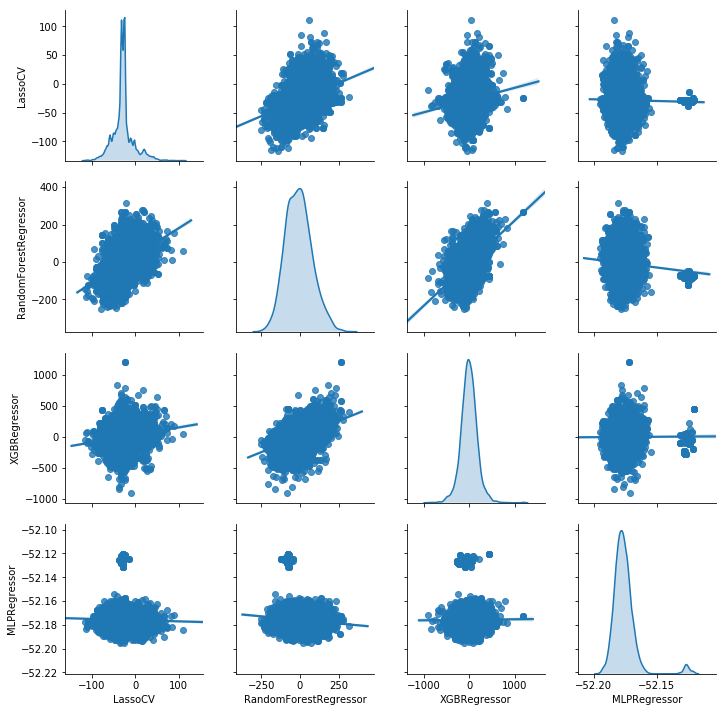

In [12]:
generate_report(results)

### Assisted Delivery

In [13]:
ad = df.loc[X.index, "good_assisted_delivery"]#"midwife_birth"]
results_ad = evaluate_models(models, y=ad)

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting dat

Correlation in median CATE:


,LassoCV,RandomForestRegressor,XGBRegressor,MLPRegressor
LassoCV,1.000000,0.834860,0.667463,0.839603
RandomForestRegressor,0.834860,1.000000,0.684585,0.651284
XGBRegressor,0.667463,0.684585,1.000000,0.554754
MLPRegressor,0.839603,0.651284,0.554754,1.000000




Best linear projection of CATE


LassoCV  MLPRegressor  RandomForestRegressor  XGBRegressor
blp 0  0.048454      0.036545               0.034505      0.034105
    1  0.391548      0.392680               0.473591      0.199353
se  0  0.021076      0.022688               0.022076      0.022571
    1  0.133713      0.135333               0.134412      0.111963



Group average treatment effects:


LassoCV  MLPRegressor  RandomForestRegressor  XGBRegressor
gate 0 -0.035179     -0.023811              -0.055052     -0.037637
     1 -0.008291      0.000062               0.002471      0.011606
     2  0.010311     -0.011979               0.036094      0.037134
     3  0.091966      0.043530               0.040598      0.038914
     4  0.167908      0.116398               0.190115      0.105647
se   0  0.039089      0.036997               0.051359      0.051326
     1  0.043619      0.044748               0.043606      0.046399
     2  0.047911      0.047412               0.042442      0.043382
     3  0.045855      0.050063               0.043810      0.046943
     4  0.051318      0.055862               0.050124      0.052119

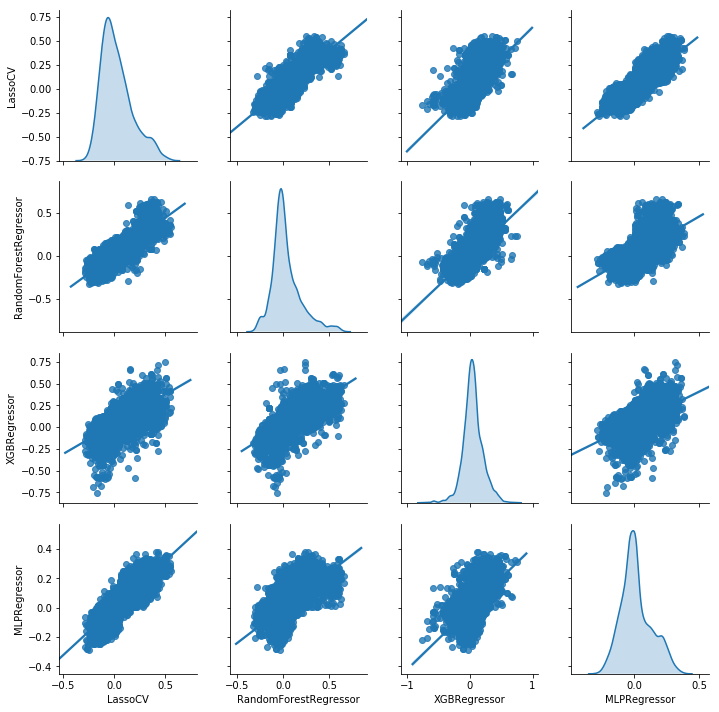

In [14]:
generate_report(results_ad)

### Covariate Means by Group

Having detected heterogeneity in grouped average treatment effects
on usage of medical profesisonals for assisted delivery, it can be
interesting to see how observables vary across groups. This could help
us understand why the treatment effect varies, or could be used to
develop simple rules for targetting future treatments.

In [15]:
df2 = df.loc[X.index, :]
df2["edu99"] = df2.edu == 99
df2["educ"] = df2["edu"]
df2.loc[df2["edu99"], "educ"] = np.nan

variables = [
    "log_xp_percap","agecat","educ","tv","goat",
    "cow","motorbike","hh_cook_wood","pkh_ever"
]

In [16]:
def cov_mean_by_group(y, res, cluster_id):
    n_group = res["gate"].shape[1]
    gate = res["gate"].copy()
    gate_se = gate.copy()
    dat = y.to_frame()

    for i in range(res["cate"].shape[1]):
        S = res["cate"][:, i]
        cutoffs = np.quantile(S, np.linspace(0, 1, n_group+1))
        cutoffs[-1] += 1
        for k in range(n_group):
            dat[f"G{k}"] = ((cutoffs[k] <= S) & (S < cutoffs[k+1])) * 1.0

        g_form = "y ~ -1 + " + " + ".join([f"G{k}" for k in range(n_group)])
        g_reg = smf.ols(g_form, data=dat.astype(float))
        g_fit = g_reg.fit()
        gate[i, :] = g_fit.params.filter(regex="G").values
        rows = ~y.isna()
        gate_se[i, :] = get_treatment_se(g_fit, cluster_id, rows)

    out = pd.DataFrame(dict(
        mean=np.nanmedian(gate, axis=0),
        se=np.nanmedian(gate_se, axis=0),
        group=list(range(n_group))
    ))

    return out

In [17]:
def compute_group_means_for_results(results):
    to_cat = []
    for res in results:
        for v in variables:
            to_cat.append(
                cov_mean_by_group(df2[v], res, loc_id)
                .assign(method=res["name"], variable=v)
            )

    group_means = pd.concat(to_cat, ignore_index=True)
    group_means["plus2sd"] = group_means.eval("mean + 1.96*se")
    group_means["minus2sd"] = group_means.eval("mean - 1.96*se")
    return group_means

In [18]:
group_means_ad = compute_group_means_for_results(results_ad)

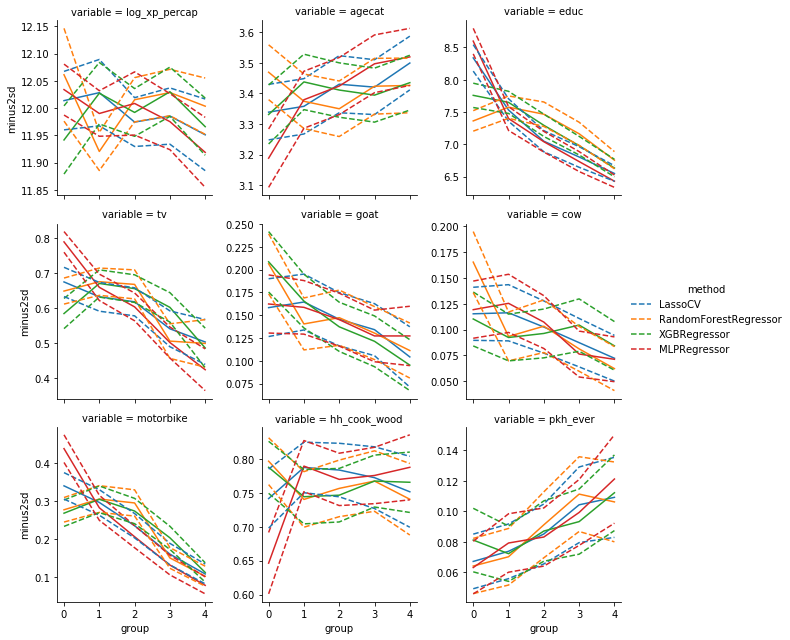

In [19]:
g = sns.FacetGrid(group_means_ad, col="variable", col_wrap=3, hue="method", sharey=False)
g.map(plt.plot, "group", "mean")
g.map(plt.plot, "group", "plus2sd", ls="--")
g.map(plt.plot, "group", "minus2sd", ls="--")
g.add_legend();

From this we see that the group predicted to have the largest
treatment effect are less educated, less likely to own a TV or
motorbike, and more likely to participate in the program.

If we wanted to maximize the program impact with a limited budget, it
would be a good idea to target the program toward less educated and
less wealthy mothers. It appears that the existing financial incentive
already does this to some extent. As one might expect, a fixed size
cash incentive has a bigger behavioral impact on less wealthy
individuals. If we want to target these individuals even more, we
could alter eligibility rules and/or make the cash transfer increase
with decreasing wealth.

### Caution

When exploring treatment heterogeneity like above, we need to be
careful in interpreting our results. In particular, looking at grouped
treatment effects and covariate means conditional on group leads to
many hypothesis tests (although we never stated null hypotheses or
reported p-values, the inevitable eye-balling of differences in the
above graphs compared to their confidence intervals has the same
issues as formal hypothesis tests).  When we perform many hypothesis
tests, it is very likely that we will stumble upon some statistically
significant differences by chance. Therefore, it would be misleading
(and perhaps unethical) to take a single large difference found in the
above analysis and write about it as though it is our main
finding. See [this excellent news article](https://slate.com/technology/2013/07/statistics-and-psychology-multiple-comparisons-give-spurious-results.html)
by statistician Andrew Gelman for more information.

## Causal Trees and Forests

[[AI16]](#athey2016b) develop the idea of “causal trees.” The purpose and
method are qualitative similar to the grouped average treatment
effects. The main difference is that the groups in [[AI16]](#athey2016b)
are determined by a low depth regression tree instead of by quantiles
of a noisy estimate of the conditional average treatment effect. As
above, sample-splitting is used to facilitate inference.

Causal trees share many of the downsides of regression trees. In
particular, the branches of the tree and subsequent results can be
sensitive to small changes in the data.  [[WA18]](#wager2018) develop a
causal forest estimator to address this concern. This causal forest
estimates $ E[y_i(1) - y_i(0) |X_i=x] $ directly. Unlike most
machine learning estimators, [[WA18]](#wager2018) prove that causal
forests are consistent and pointwise asymptotically normal, albeit
with a slower than $ \sqrt{n} $ rate of convergence. In practice,
this means that either the sample size must be very large (and/or $ x $
relatively low dimension) to get precise estimates.

## References

<a id='alatas2011'></a>
\[ACE+11\] Vivi Alatas, Nur Cahyadi, Elisabeth Ekasari, Sarah Harmoun, Budi Hidayat, Edgar Janz, Jon Jellema, H Tuhiman, and M Wai-Poi. Program keluarga harapan : impact evaluation of indonesia’s pilot household conditional cash transfer program. Technical Report, World Bank, 2011. URL: [http://documents.worldbank.org/curated/en/589171468266179965/Program-Keluarga-Harapan-impact-evaluation-of-Indonesias-Pilot-Household-Conditional-Cash-Transfer-Program](http://documents.worldbank.org/curated/en/589171468266179965/Program-Keluarga-Harapan-impact-evaluation-of-Indonesias-Pilot-Household-Conditional-Cash-Transfer-Program).

<a id='athey2016b'></a>
\[AI16\] Susan Athey and Guido Imbens. Recursive partitioning for heterogeneous causal effects. *Proceedings of the National Academy of Sciences*, 113(27):7353–7360, 2016. URL: [http://www.pnas.org/content/113/27/7353](http://www.pnas.org/content/113/27/7353), [arXiv:http://www.pnas.org/content/113/27/7353.full.pdf](https://arxiv.org/abs/http://www.pnas.org/content/113/27/7353.full.pdf), [doi:10.1073/pnas.1510489113](https://doi.org/10.1073/pnas.1510489113).

<a id='chernozhukov2018'></a>
\[CCD+18\] Victor Chernozhukov, Denis Chetverikov, Mert Demirer, Esther Duflo, Christian Hansen, Whitney Newey, and James Robins. Double/debiased machine learning for treatment and structural parameters. *The Econometrics Journal*, 21(1):C1–C68, 2018. URL: [https://onlinelibrary.wiley.com/doi/abs/10.1111/ectj.12097](https://onlinelibrary.wiley.com/doi/abs/10.1111/ectj.12097), [arXiv:https://onlinelibrary.wiley.com/doi/pdf/10.1111/ectj.12097](https://arxiv.org/abs/https://onlinelibrary.wiley.com/doi/pdf/10.1111/ectj.12097), [doi:10.1111/ectj.12097](https://doi.org/10.1111/ectj.12097).

<a id='cddf2018'></a>
\[CDDFV18\] Victor Chernozhukov, Mert Demirer, Esther Duflo, and Iván Fernández-Val. Generic machine learning inference on heterogenous treatment effects in randomized experimentsxo. Working Paper 24678, National Bureau of Economic Research, June 2018. URL: [http://www.nber.org/papers/w24678](http://www.nber.org/papers/w24678), [doi:10.3386/w24678](https://doi.org/10.3386/w24678).

<a id='kleinberg2017'></a>
\[KLL+17\] Jon Kleinberg, Himabindu Lakkaraju, Jure Leskovec, Jens Ludwig, and Sendhil Mullainathan. Human Decisions and Machine Predictions*. *The Quarterly Journal of Economics*, 133(1):237–293, 08 2017. URL: [https://dx.doi.org/10.1093/qje/qjx032](https://dx.doi.org/10.1093/qje/qjx032), [arXiv:http://oup.prod.sis.lan/qje/article-pdf/133/1/237/24246094/qjx032.pdf](https://arxiv.org/abs/http://oup.prod.sis.lan/qje/article-pdf/133/1/237/24246094/qjx032.pdf), [doi:10.1093/qje/qjx032](https://doi.org/10.1093/qje/qjx032).

<a id='kleinberg2015'></a>
\[KLMO15\] Jon Kleinberg, Jens Ludwig, Sendhil Mullainathan, and Ziad Obermeyer. Prediction policy problems. *American Economic Review*, 105(5):491–95, May 2015. URL: [http://www.aeaweb.org/articles?id=10.1257/aer.p20151023](http://www.aeaweb.org/articles?id=10.1257/aer.p20151023), [doi:10.1257/aer.p20151023](https://doi.org/10.1257/aer.p20151023).

<a id='triyana2016'></a>
\[Tri16\] Margaret Triyana. Do health care providers respond to demand-side incentives? evidence from indonesia. *American Economic Journal: Economic Policy*, 8(4):255–88, November 2016. URL: [http://www.aeaweb.org/articles?id=10.1257/pol.20140048](http://www.aeaweb.org/articles?id=10.1257/pol.20140048), [doi:10.1257/pol.20140048](https://doi.org/10.1257/pol.20140048).

<a id='wager2018'></a>
\[WA18\] Stefan Wager and Susan Athey. Estimation and inference of heterogeneous treatment effects using random forests. *Journal of the American Statistical Association*, 0(0):1–15, 2018. URL: [https://doi.org/10.1080/01621459.2017.1319839](https://doi.org/10.1080/01621459.2017.1319839), [arXiv:https://doi.org/10.1080/01621459.2017.1319839](https://arxiv.org/abs/https://doi.org/10.1080/01621459.2017.1319839), [doi:10.1080/01621459.2017.1319839](https://doi.org/10.1080/01621459.2017.1319839).